# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
pip install google.colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/My Drive/ratings_Electronics.csv"

**Installing surprise library**

In [4]:
pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [5]:
import pandas as pd
from collections import defaultdict


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [6]:
df_init = pd.read_csv(file_path, low_memory=False, names=['user_id', 'prod_id', 'rating', 'timestamp'])
df_cleaned = df_init.drop(columns=['timestamp'])
df = df_cleaned.copy()


In [7]:
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [8]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [9]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [10]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [11]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [12]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

*   List item
*   List item



In [13]:
# Check the number of rows and columns and provide observations
df.shape

(125871, 3)

**Write your observations here: 125871 row entries, 3 column attributes**

### **Data types**

In [14]:
# Check Data types and provide observations
df.dtypes

,0
user_id,object
prod_id,object
rating,float64


**Write your observations here: user_id/prod_id has type object and ratings is a float type**

### **Checking for missing values**

In [15]:
# Check for missing values present and provide observations
df.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here:0 missing values**

### **Summary Statistics**

In [16]:
# Summary statistics of 'rating' variable and provide observations
df.describe()

,rating
count,125871.000000
mean,4.261339
std,1.062144
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here: numerical summary statistics of the rating attribute with a minimum of 1, a maximum of 5 and an average rating of 4.26**

### **Checking the rating distribution**

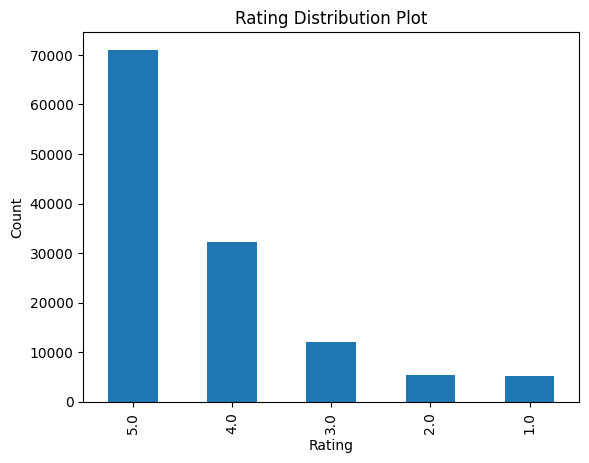

In [17]:
# Create the bar plot and provide observations
import matplotlib.pyplot as plt

rating_counts = df['rating'].value_counts()
rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution Plot')

plt.show()

**Write your observations here:Majority of the ratings are 5:
- 5 has a count over 70000
- 4 has a count over 30000
- 3 has a count over 10000
- 2 has a count around 5000
- 1 has a count below 5000**

### **Checking the number of unique users and items in the dataset**

In [18]:
# Number of total rows in the data and number of unique user id and product id in the data
total_rows = len(df)
unique_users = df['user_id'].nunique()
unique_products = df['prod_id'].nunique()

print(total_rows, unique_users, unique_products)

125871 1540 48190


** Write your observations here:
- Total number of rows: 125871
- Number of unique user_ids: 1540
- Number of unique prod_ids: 48190 **

### **Users with the most number of ratings**

**Write your observations here:
The users are ranked based on the number of ratings provided. Users are represented by their user_id with the highest count of 520 and the 10th place of 296 ratings**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [20]:
# Calculate the average rating for each product
avg_ratings = df.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_ratings = df.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'average_rating': avg_ratings,
    'rating_count': count_ratings
})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)


# See the first five records of the "final_rating" dataset
print(final_rating.head())


            average_rating  rating_count
prod_id                                 
0594451647             5.0             1
B003RRY9RS             5.0             1
B003RR95Q8             5.0             1
B003RIPMZU             5.0             1
B003RFRNYQ             5.0             2


In [21]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(df, n, min_interactions):
    avg_ratings = df.groupby('prod_id')['rating'].mean()
    count_ratings = df.groupby('prod_id')['rating'].count()

    product_stats = pd.DataFrame({
        'average_rating': avg_ratings,
        'rating_count': count_ratings
    })

    filtered_products = product_stats[product_stats['rating_count'] >= min_interactions]

    sorted_products = filtered_products.sort_values(by='average_rating', ascending=False)

    return sorted_products.head(n)


# Finding products with minimum number of interactions
top_n = get_top_n_products(df, n=10, min_interactions=5)
print(top_n)

# Sorting values with respect to average rating


            average_rating  rating_count
prod_id                                 
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8
B003CK10DG             5.0             5
B003B41XYO             5.0             5
B0007WK8KS             5.0             6
B0084FM5JC             5.0             5
B005GI2VMG             5.0            10


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
top_n = get_top_n_products(df, n=5, min_interactions=50)
top_n

,average_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
top_n = get_top_n_products(df, n=5, min_interactions=100)
top_n

,average_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [24]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [25]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [26]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [27]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True,
    'min_support': 5
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_model = KNNBasic(sim_options=sim_options, verbose=False)


# Fit the model on the training data
knn_model.fit(trainset)


# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_model)

RMSE: 1.0836
Precision:  0.826
Recall:  0.713
F_1 score:  0.765


**Write your observations here:
- Prediction ratings can be off by 1
- There is an 82.6% chance of product relevance for users
- 71.3% products were recommended by the model
- An overall rating of 76.5% balancing the precision and recall**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [28]:
# Predicting rating for a sample user with an interacted product
predicted_rating = knn_model.predict('A3LDPF5FMB782Z', '1400501466')
predicted_rating

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

**Write your observations here:
THe model prediciton aligns with what we already know about the user giving a rating of 5, showcasing a good accuracy **

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [29]:
# Find unique user_id where prod_id is not equal to "1400501466"
unique_users = df[df['prod_id'] != "1400501466"]['user_id'].unique()
unique_users_list = unique_users.tolist()
unique_users_list

['A3BY5KCNQZXV5U',
 'AT09WGFUM934H',
 'A32HSNCNPRUMTR',
 'A17HMM1M7T9PJ1',
 'A3CLWR1UUZT6TG',
 'A3TAS1AG6FMBQW',
 'A2Y4H3PXB07WQI',
 'A25RTRAPQAJBDJ',
 'A3LDPF5FMB782Z',
 'A18S2VGUH9SCV5',
 'A1K4G5YJDJQI6Q',
 'A1PPS91NLI7KEH',
 'A2ZR3YTMEEIIZ4',
 'A5JLAU2ARJ0BO',
 'A1P4XD7IORSEFN',
 'A341HCMGNZCBIT',
 'A3HPCRD9RX351S',
 'A20UU20K7M9ZPF',
 'A1DQHS7MOVYYYA',
 'ALUNVOQRXOZIA',
 'A19N3S7CBSU6O7',
 'A3G7BEJJCPD6DS',
 'A2JXS1JII6SAUD',
 'A2JOPUWVV0XQJ3',
 'A3PD8JD9L4WEII',
 'ABVYGB2TKBO8F',
 'A1NAA1R38JSNHV',
 'A1U5IJHJK84S54',
 'A30X750M8V1XXW',
 'A3QQGPI3CTV9SX',
 'A2JWF9IG8PJAOA',
 'A1ZU55TM45Y2R8',
 'A1VQHH85U7PX0',
 'A5A4374R8I7NB',
 'A10X9ME6R66JDX',
 'A14I1F2H7NOYDC',
 'A328GLDSDNFYII',
 'AAEVGE52KL0DJ',
 'A36K2N527TXXJN',
 'ADLVFFE4VBT8',
 'A3OZA8HNJM26DC',
 'A19HT7YC1UW3D6',
 'A16HXVNPU5TCGE',
 'A250AXLRBVYKB4',
 'A1C82BC5GNABOA',
 'A1VHCO8RQFIGQJ',
 'A2Z9S2RQD542CP',
 'A2QIC4G483SQQA',
 'A3L6L5O89JTX2T',
 'A1OGCPMSIVK7G4',
 'A18HE80910BTZI',
 'A3F9CBHV4OHFBS',
 'A2WXURU33RBGQS',
 '

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [30]:
# Predicting rating for a sample user with a non interacted product
predicted_rating = knn_model.predict('A34BZM6S9L7QI4', '1400501466')
predicted_rating

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.263416620322555, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:
The model estimates a 4.26 rating but could not make a confident prediction due to insufficient neighbors/data**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [31]:
def load_data_in_chunks(df, chunk_size):
    for i in range(0, len(df), chunk_size):
        yield df[i:i+chunk_size]

reader = Reader(rating_scale=(1, 5))

def process_chunk(chunk_df):
    param_grid = {
        'k': [5, 10, 20],
        'min_k': [1, 5],
        'sim_options': {
            'name': ['cosine', 'msd'],
            'user_based': [True]
        }
    }

    # Perform 3-fold cross-validation to tune the hyperparameters
    grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

    # Fit the model
    grid_search.fit(data)

    # Return the best RMSE and best parameters from this chunk
    best_rmse = grid_search.best_score['rmse']
    best_params = grid_search.best_params['rmse']

    return best_rmse, best_params

chunk_size = 10000

best_rmse_overall = float('inf')
best_params_overall = None

for chunk in load_data_in_chunks(df, chunk_size):
    best_rmse, best_params = process_chunk(chunk)

    if best_rmse < best_rmse_overall:
        best_rmse_overall = best_rmse
        best_params_overall = best_params

print(f"Best RMSE score overall: {best_rmse_overall}")
print("Best combination of parameters overall:")
print(best_params_overall)



Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarit

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [32]:
# Using the optimal similarity measure for user-user based collaborative filtering
optimal_k = best_params['k']
optimal_sim_options = best_params['sim_options']

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_final_model = KNNBasic(k=optimal_k, sim_options=optimal_sim_options, verbose=False)

# Training the algorithm on the trainset
knn_final_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(knn_final_model, k=10)


RMSE: 1.1112
Precision:  0.846
Recall:  0.718
F_1 score:  0.777


**Write your observations here:There's an increased precision after hyperparameter tuning and a slightly higher error range. The overall F1 score has made an improvement **

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [33]:

prediction = knn_final_model.predict(uid='A3LDPF5FMB782Z', iid='1400501466')

print(f"Predicted rating for user 'A3LDPF5FMB782Z' and product '1400501466': {prediction.est}")

Predicted rating for user 'A3LDPF5FMB782Z' and product '1400501466': 4.73758865248227


In [34]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction = knn_final_model.predict(uid='A34BZM6S9L7QI4', iid='1400501466')

prediction.est

3.0

**Write your observations here:**The previous model wasn't able to give me a prediction but the current model is able to make one after tuning the parameters to predict their rating even without product interaction

> Add blockquote



### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [35]:
# 0 is the inner id of the above user
user_inner_id = 0

similar_users = knn_final_model.get_neighbors(user_inner_id, k=5)

similar_user_ids = [trainset.to_raw_uid(inner_id) for inner_id in similar_users]

similar_user_ids

['A3F9CBHV4OHFBS',
 'A3MQAQT8C6D1I7',
 'A5JLAU2ARJ0BO',
 'A15QYHQH80W30L',
 'A2I2KPNJDQ9SL0']

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [36]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

[link text](https://)**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [37]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_recommendations = get_recommendations(df, "A3LDPF5FMB782Z", 5, knn_final_model)


In [38]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommended_df = pd.DataFrame(top_5_recommendations, columns=["prod_id", "predicted_ratings"])
recommended_df

,prod_id,predicted_ratings
0,1400599997,5
1,1685560148,5
2,787988002X,5
3,8862935307,5
4,9983891212,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [39]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item_model = KNNBasic(sim_options=sim_options, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
trainset, testset = train_test_split(data, test_size=0.25, random_state=1)
knn_item_model.fit(trainset)
test_predictions = knn_item_model.test(testset)


# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item_model, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0940
Precision:  0.829
Recall:  0.589
F_1 score:  0.689


**Write your observations here:**Item to item similarity has a higher precision score but lower f1 score. Metrics suggest that there is an error margin of 1.09, precision of 82.9%, recall of 58.9% and an overall balance of 68.9%.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [40]:
# Predicting rating for a sample user with an interacted product
prediction = knn_item_model.predict(uid='A3LDPF5FMB782Z', iid='1400501466')
prediction

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.225, details={'actual_k': 40, 'was_impossible': False})

**Write your observations here:**Estimated prediction of 4.225 rating

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [41]:
# Predicting rating for a sample user with a non interacted product
prediction = knn_item_model.predict(uid='A34BZM6S9L7QI4', iid='1400501466')
prediction

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:**Estimated rating of 4.4

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [42]:
def chunked_data(data, chunk_size):
    for start in range(0, len(data), chunk_size):
        yield data[start:start + chunk_size]

reader = Reader(rating_scale=(1, 5))


# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]  # Item-item collaborative filtering
    }
}
# Performing 3-fold cross validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

chunk_size = 1000
# Fitting the data
for chunk in chunked_data(df[['user_id', 'prod_id', 'rating']], chunk_size):
    data_chunk = Dataset.load_from_df(chunk, reader)
    grid_search.fit(data_chunk)

# Find the best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE score: {best_rmse}")

# Find the combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best combination of parameters:", best_params)

Streaming output truncated to the last 5000 lines.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computin

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [43]:
# Using the optimal similarity measure for item-item based collaborative filtering
best_params = grid_search.best_params['rmse']

# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_model = KNNBasic(k=best_params['k'],
                            min_k=best_params['min_k'],
                            sim_options=best_params['sim_options'])

# Training the algorithm on the trainset
optimized_model.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(optimized_model, 10, 3.5)

predictions = optimized_model.test(testset)
rmse_optimized = accuracy.rmse(predictions)
print(f'Optimized Model RMSE: {rmse_optimized}')


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0583
Precision:  0.828
Recall:  0.594
F_1 score:  0.692
RMSE: 1.0583
Optimized Model RMSE: 1.0582648077886354


**Write your observations here:There is a slight improvement in the scores when comparing the base model and the optimized model. The rmse error range is lower and the overall balance between precision and recall is comparitively higher. **

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [45]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
prediction = optimized_model.predict('A3LDPF5FMB782Z', '1400501466')
prediction

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=5, details={'actual_k': 10, 'was_impossible': False})

In [46]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction = optimized_model.predict('A34BZM6S9L7QI4', '1400501466')
prediction

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.526315789473684, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:Estimated prediction rating of 4.53**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [44]:
similar_items = knn_model.get_neighbors(0, k=5)


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [49]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df, 'A1A5KUIIIHFF4U', 5, optimized_model)
recommendations

[('B00004SABB', 5),
 ('B00005108H', 5),
 ('B000067RC4', 5),
 ('B0001FTVEK', 5),
 ('B0001Y7UAI', 5)]

In [50]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=["prod_id", "predicted_ratings"])

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [51]:
# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)


# Training the algorithm on the trainset
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)


RMSE: 0.9850
Precision:  0.845
Recall:  0.592
F_1 score:  0.696


**Write your observations here:svd matrix factorization shows a low rmse error margin and a higher f1 score, likely because it's easier to predict user behavior based on their purchase history**

[link text](https://)**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [52]:
# Making prediction
prediction = svd_model.predict('A3LDPF5FMB782Z', '1400501466')
prediction

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.228001903569834, details={'was_impossible': False})

**Write your observations here:Estimated prediction rating of 4.22**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [53]:
# Making prediction
prediction = svd_model.predict('A34BZM6S9L7QI4', '1400501466')
prediction

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.579075505517537, details={'was_impossible': False})

**Write your observations here:Estimated prediction rate of 4.57**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [57]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [5, 10, 15],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}


# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Fitting data
gs.fit(data)

# Best RMSE score
print(f"Best RMSE score: {gs.best_score['rmse']:.4f}")

# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs.best_params['rmse'])


Best RMSE score: 0.9813
Best parameters: {'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [59]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
best_params = gs.best_params['rmse']

optimized_svd = SVD(n_epochs=best_params['n_epochs'],
                    lr_all=best_params['lr_all'],
                    reg_all=best_params['reg_all'],
                    random_state=1)

# Train the algorithm on the trainset
optimized_svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd, k=10)

RMSE: 0.9786
Precision:  0.852
Recall:  0.6
F_1 score:  0.704


**Write your observations here:THe final optimized model shows an improvement again in precision, recall and balance F1 score.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [60]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
prediction = optimized_svd.predict('A3LDPF5FMB782Z', '1400501466')
prediction

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.135834388197101, details={'was_impossible': False})

In [61]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction = optimized_svd.predict('A3LDA34BZM6S9L7QI4PF5FMB782Z', '1400501466')
prediction

Prediction(uid='A3LDA34BZM6S9L7QI4PF5FMB782Z', iid='1400501466', r_ui=None, est=4.1205321579711995, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

After building and optimizing all the models for item-item, user-user, user-item, the model that shows the best overall performance based on the scores is the optimized svg model with a high precision and low rsme error margin.

It is recommended to implement the following for improvements in business outcomes:

1. Combine all recommendation system models for robust recommendations.

2. Develop the database with more column attributes such as detailed user information like demographics, preferences, product features, etc.

3. Implement top product contents recommendation for new users to provide optimal recommendations, then improve the content based on user purchases.